In [1]:
import numpy
import numpy.ma as ma
import scipy.signal
import shapely
from shapely.geometry import Polygon as PPGON
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.fill import fillnodata
from rasterio.mask import mask
import rasterio
from osgeo import gdal
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
from skimage import io, data, img_as_float
from skimage import exposure
from rasterio.plot import show_hist
import geopandas as gpd
import subprocess as sp
import xrspatial
import glob
import osmnx as ox
import zipfile
from sklearn.cluster import KMeans
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
ox.config(use_cache=True, log_console=True)
import ee
import geemap

/srv/conda/envs/env_snap/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
service_account = 'pandas@dev-ind-geo-01.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '/workspace/snapdocker/credentials.json')
ee.Initialize(credentials=credentials)

In [3]:
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
    '/workspace/snapdocker/credentials.json',
)

<AxesSubplot:>

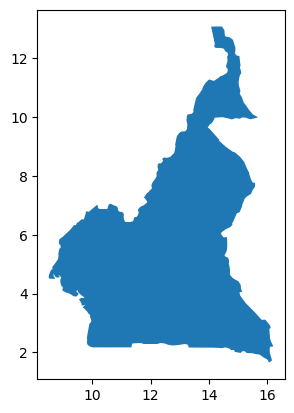

In [4]:
camr = gpd.read_file('/workspace/sentinelproduct/cameroon/cmr/cmr.shp')
camr.plot()

In [7]:
aoi = geemap.geopandas_to_ee(camr).geometry()

In [12]:
region=aoi.getInfo()

In [31]:
# start_date = '2021-03-01'
# end_date = '2021-03-31'
# capture_date = '20210331'

# start_date = '2021-04-01'
# end_date = '2021-04-30'
# capture_date = '20210430'

# start_date = '2021-05-01'
# end_date = '2021-05-31'
# capture_date = '20210531'

# start_date = '2021-06-01'
# end_date = '2021-06-30'
# capture_date = '20210630'

start_date = '2021-07-01'
end_date = '2021-07-31'
capture_date = '20210731'



In [17]:
# Function to mask clouds using the Sentinel-2 QA band

def se2mask(image):
    quality_band = image.select('QA60')
    
    # using the bit mask for clouds and cirrus clouds respectively
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    
    # we only want clear skies
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    
    # we'll divide by 10000 to make interpreting the reflectance values easier
    return image.updateMask(mask).divide(10000)

In [32]:
se2 = (ee.ImageCollection('COPERNICUS/S2')
        .filterDate(start_date,end_date)
        .filterBounds(aoi)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",80))
        .map(se2mask)
        .select(['B2','B3','B4','B8'])
        .median())

In [33]:
rgb = ['B4','B3','B2']

# set some thresholds
rgbViz = {"min":0.0, "max":0.3,"bands":rgb}


# initialize our map
map1 = geemap.Map()
map1.centerObject(aoi, 7)
map1.addLayer(se2.clip(aoi), rgbViz, "S2")
# map1.addLayer(landcover.clip(aoi), {}, 'Land Cover')
region_im = ee.Image().byte().paint(
    featureCollection=ee.Geometry(region), width=2, color=1
)
map1.addLayer(region_im, dict(palette=['FF0000']), 'Region')
map1.addLayerControl()
map1

Map(center=[5.676077145623018, 12.737897386736984], controls=(WidgetControl(options=['position', 'transparent_…

In [34]:
outputBucket = 'geotiff01' #Change for your Cloud Storage bucket

# Export the image, specifying scale and region.
task = ee.batch.Export.image.toCloudStorage(**{
    'image': se2.clip(aoi),
    'description': capture_date+'_',
    'region': aoi,
    'fileFormat': 'GeoTIFF',
    'bucket': outputBucket,
    'formatOptions': {'cloudOptimized': False},
    'path':'cameroondata/raw/whole/'+capture_date+'/',
    'scale':10,
    'maxPixels':int(1e13)
})

task.start()
import time 
count = 1
while task.active():
    print(f'{count}' + ': Polling for task (id: {}).'.format(task.id))
    time.sleep(600)
    count +=1

1: Polling for task (id: J6V5TBHSN3CPFO36LYVVGRBD).


KeyboardInterrupt: 

### gsutil cp "gs://geotiff01/cameroondata/raw/whole/20210630/*.tif" sentinelproduct/cameroon/whole/20210630/